In [1]:
import numpy as np
import timeit

from scipy.sparse import identity
from graspologic.inference import latent_position_test
from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspologic.simulations import er_np, sbm, rdpg
from graspologic.utils import symmetrize
from graspologic.plot import heatmap, pairplot
from graspologic.align import OrthogonalProcrustes

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sknetwork.data import erdos_renyi, painters, movie_actor
from sknetwork.embedding import Spectral, SVD
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from IPython.display import SVG

Sim setting:

Sim 1: SVD vs ASE

n_verts = [10, 100, 1000, 10000, 100000]
Generate an nx1 2D array of latent positions of uniform distribution between 0.1 and 1
Generate an RDPG from the 2D array
Perform ASE and SVD on the RDPG (with n_components=1) and save the runtimes for each using the timeit.default_timer() method
Take the frobenius norm of the latent positions from ASE/SVD and the true latent positions
Repeat steps 2-5 for 15 trials per n
Plot stripplots for times vs n_verts for ASE and SVD
Plot stripplots for frobenius norms vs n_verts for ASE and SVD

In [2]:
n_verts = [10, 100, 500, 1000, 10000]
total_verts = []
time_ASE = []
time_SVD = []
norms_ASE = []
norms_SVD = []

In [3]:
for n in n_verts:
    for _ in range(15):
        
        total_verts.append(n)
        X = np.random.uniform(low=0.1, high=1, size=(n, 1))
        norm = np.linalg.norm(X, axis=0)
        X = X/norm
        A = rdpg(X)
        
        #get time for running ASE
        start_time = timeit.default_timer()
        ase = AdjacencySpectralEmbed(n_components=1, check_lcc=False)
        X1 = ase.fit_transform(A)
        norm1 = np.linalg.norm(X1, axis=0)
        X1 = X1/norm1
        elapsed_ASE = timeit.default_timer() - start_time
        time_ASE.append(elapsed_ASE)
        
        #get norm of X@Q-X1
        aligner_OP1 = OrthogonalProcrustes()
        X_prime_OP1 = aligner_OP1.fit_transform(X, X1)
        Q1 = aligner_OP1.Q_
        norm_ASE = np.linalg.norm(X@Q1-X1, ord='fro')
        norms_ASE.append(norm_ASE)
        
        #get time for running SVD
        start_time = timeit.default_timer()
        svd = SVD(1)
        X2 = svd.fit_transform(A)
        norm2 = np.linalg.norm(X2, axis=0)
        X2 = X2/norm2
        elapsed_SVD = timeit.default_timer() - start_time
        time_SVD.append(elapsed_SVD)
        
        #get norm of X@Q-X2
        aligner_OP2 = OrthogonalProcrustes()
        X_prime_OP2 = aligner_OP2.fit_transform(X, X2)
        Q2 = aligner_OP2.Q_
        norm_SVD = np.linalg.norm(X@Q2-X2, ord='fro')
        norms_SVD.append(norm_SVD)
        
        print(n)

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


In [4]:
time_ASE_dict = {"time_ASE": time_ASE, "n_verts": total_verts}
df_time_ASE = pd.DataFrame(data = time_ASE_dict)

In [5]:
norms_ASE_dict = {"norms_ASE": norms_ASE, "n_verts": total_verts}
df_norms_ASE = pd.DataFrame(data = norms_ASE_dict)

In [6]:
time_SVD_dict = {"time_SVD": time_SVD, "n_verts": total_verts}
df_time_SVD = pd.DataFrame(data = time_SVD_dict)

In [7]:
norms_SVD_dict = {"norms_SVD": norms_SVD, "n_verts": total_verts}
df_norms_SVD = pd.DataFrame(data = norms_SVD_dict)

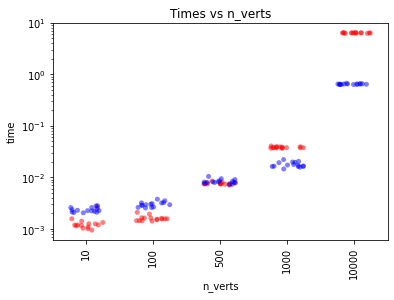

In [8]:
ax1 = sns.stripplot(data=df_time_ASE,
    x="n_verts",
    y="time_ASE",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='red'
)

ax2 = sns.stripplot(data=df_time_SVD,
    x="n_verts",
    y="time_SVD",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='blue'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('time')
plt.title("Times vs n_verts")

plt.savefig('timeASESVD_vs_n_verts.png')

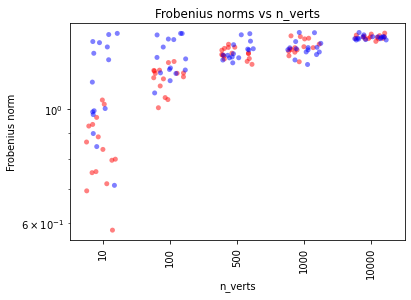

In [9]:
ax1 = sns.stripplot(data=df_norms_ASE,
    x="n_verts",
    y="norms_ASE",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='red'
)

ax2 = sns.stripplot(data=df_norms_SVD,
    x="n_verts",
    y="norms_SVD",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='blue'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('Frobenius norm')
plt.title("Frobenius norms vs n_verts")

plt.savefig('normsASESVD_vs_n_verts.png')

In [19]:
n_verts = [10, 100, 500, 1000, 10000]
total_verts = []
time_LSE = []
time_Spectral = []
norms_LSE = []
norms_Spectral = []

In [20]:
for n in n_verts:
    for _ in range(15):
        
        total_verts.append(n)
        X = np.random.uniform(low=0.1, high=1, size=(n, 1))
        norm = np.linalg.norm(X, axis=0)
        X = X/norm
        A = rdpg(X)
        
        #get time for running LSE
        start_time = timeit.default_timer()
        lse = LaplacianSpectralEmbed(n_components=1, check_lcc=False)
        X1 = lse.fit_transform(A)
        norm1 = np.linalg.norm(X1, axis=0)
        X1 = X1/norm1
        elapsed_LSE = timeit.default_timer() - start_time
        time_LSE.append(elapsed_LSE)
        
        #get norm of X@Q-X1
        aligner_OP1 = OrthogonalProcrustes()
        X_prime_OP1 = aligner_OP1.fit_transform(X, X1)
        Q1 = aligner_OP1.Q_
        norm_LSE = np.linalg.norm(X@Q1-X1, ord='fro')
        norms_LSE.append(norm_LSE)
        
        #get time for running Spectral
        start_time = timeit.default_timer()
        spectral = Spectral(1)
        X2 = spectral.fit_transform(A)
        norm2 = np.linalg.norm(X2, axis=0)
        X2 = X2/norm1
        elapsed_Spectral = timeit.default_timer() - start_time
        time_Spectral.append(elapsed_Spectral)
        
        #get norm of X@Q-X2
        aligner_OP2 = OrthogonalProcrustes()
        X_prime_OP2 = aligner_OP2.fit_transform(X, X2)
        Q2 = aligner_OP2.Q_
        norm_Spectral = np.linalg.norm(X@Q2-X2, ord='fro')
        norms_Spectral.append(norm_LSE)
        
        print(n)

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


In [21]:
print(total_verts)
print(norms_LSE)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
[1.2563811796514193, 1.2943827776180121, 1.2117782299538722, 1.2690185156644034, 1.238920314048759, 0.9231276430290968, 1.1476490107172057, 1.4067938019275095, 0.9328478010527796, 0.6567300206928421, 1.3175367748271947, 1.2537474822682548, 1.3523210520382007, 1.125807865274665, 0.5227092517083014, 1.3495886221183357, 1.141161354759553, 1.3197941320595141, 1.131453987331494, 1.3322432893598863, 1.4110756449328692, 1.3741168573781277, 1.308576008429948, 1.1907058565288586, 1.3643113146523285, 1.3209530249591968, 1.1732778211666197, 1.2590001849758319, 1.2596086248891585, 1.270319070867696,

In [22]:
time_LSE_dict = {"time_LSE": time_LSE, "n_verts": total_verts}
df_time_LSE = pd.DataFrame(data = time_LSE_dict)

In [23]:
norms_LSE_dict = {"norms_LSE": norms_LSE, "n_verts": total_verts}
df_norms_LSE = pd.DataFrame(data = norms_LSE_dict)

In [24]:
time_Spectral_dict = {"time_Spectral": time_Spectral, "n_verts": total_verts}
df_time_Spectral = pd.DataFrame(data = time_Spectral_dict)

In [25]:
norms_Spectral_dict = {"norms_Spectral": norms_Spectral, "n_verts": total_verts}
df_norms_Spectral = pd.DataFrame(data = norms_Spectral_dict)

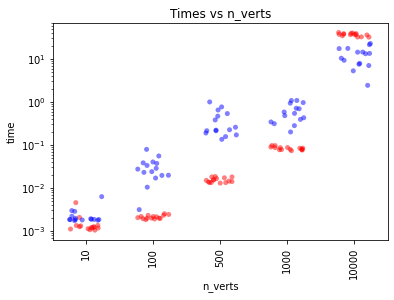

In [26]:
ax1 = sns.stripplot(data=df_time_LSE,
    x="n_verts",
    y="time_LSE",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='red'
)

ax2 = sns.stripplot(data=df_time_Spectral,
    x="n_verts",
    y="time_Spectral",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='blue'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('time')
plt.title("Times vs n_verts")

plt.savefig('timeLSESpectral_vs_n_verts.png')

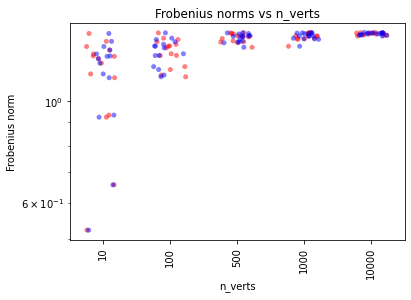

In [27]:
ax1 = sns.stripplot(data=df_norms_LSE,
    x="n_verts",
    y="norms_LSE",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='red'
)

ax2 = sns.stripplot(data=df_norms_Spectral,
    x="n_verts",
    y="norms_Spectral",
    jitter = 0.25,
    alpha = 0.5,
    size=5,
    color='blue'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('Frobenius norm')
plt.title("Frobenius norms vs n_verts")

plt.savefig('normsLSESpectral_vs_n_verts.png')